# CSCA 5642 - Deep Learning Final Project


## Problem Description 

### Project Topic

The topic of this project is Reinforcement Learning but also Deep Learning as this project will use Deep Q Learning (DQN) which involves multilayer Neural Networks like we have been using throughout the CSCA5642 class. I was interested in Reinforcement Learning before taking this Course Specialization and was hoping we would go over this in one of our classes. Since we did not go over it, I am doing my final project on Reinforcement Learning and how Deep Learning can be used to tackle RL problems.

![Problem Description](images/problem_description.png)

The Machine Learning problem provided at the link below is a simple Reinforcement Learning Game. In this game there is a cart that is confined to moving in one dimension, left or right. On top of the cart there is a balanced pole and the pole will fall over if not corrected by movements of the cart. The cart may move either left or right to keep the pole balanced on top of the cart. The goal of this project is to balance the pole ontop of the cart for up to 500 steps.

### Data Description

Source for Project Data:
https://www.gymlibrary.dev/environments/classic_control/cart_pole/

Citation:

Gym Library. (n.d.). CartPole-v1. Gymnasium. Retrieved November 23, 2024, from https://www.gymlibrary.dev/environments/classic_control/cart_pole/


Unlike all of the other projects in the CSCA Machine Learning Class Specialization, the data for this problem does not come pre-packaged for our use. Instead, we access a simulated environment using the Gym Library for python. This simulated environment for "CartPole-v1" will give us four data points for any given point in the simulation: Cart Position, Cart Velocity, Pole Angle, and Pole Angular Velocity. Instead of a pre-filled out table with many combinations of these values to train on, we must run the simulation and have our model take actions and observe how these parameters change. So this project will involve running many hundreds of simulations to produce many thousands of data points for our model to learn from.

There is no 'size' of this data. The size of the data is up to how much data the user would like to generate when training models.

| State Variable | Limits |
|---------------|---------------|
| Cart Position |  +/- 4.8 |
| Cart Velocity  | No Limits  |
| Pole Angle  | +/- .418 rad  |
| Pole Ang. Velocity  | No Limits   |

![Boundaries for data](images/boundaries.png)


## Exploratory Data Analysis

As with any Machine Learning problem, it is important to understand the data and what is available to train our models on. In addition there are data preparation steps that need to be taken in order to set up our models for success.

### Note on Correlation
Our data is somewhat interesting relative to the other datasets that were used in the CSCA Machine Learning Specialization, as it is generated on the fly and not provided. The data that is available to train on is very simple, and is not correlated in the way that other ML datasets can be correlated. Therefore it does not make sense to include a correlation matrix for this data.

In [1]:
# Lets Start by Handling all of our imports
import os
import gym
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import pandas as pd
from matplotlib import pyplot as plt

### Data Exploration

Let's explore the dataset and see what we have to work with to model this problem.

In [2]:
# Load in the CartPole Simulation
env = gym.make("CartPole-v1")

Start by taking a look at what actions we have available for our models to take:

In [3]:
# Lets Observe the action space
print("Environment Action Space:")
print(env.action_space)

N_ACTIONS = env.action_space.n

Environment Action Space:
Discrete(2)


We can see that our action space (the actions we are trying to predict/recommend to take) are a discrete set of 2 values. So a binary classification style prediction.

In other words, the actions we can take with the cart are 0 and 1, for left and right.

Next, lets take a look at the state space or observation space:

In [4]:
# Lets look at the observation space
print("Environment Observation Space:")
print(env.observation_space)

print("")
print("Lower Bounds")
print(env.observation_space.low)
print("")
print("Upper Bounds")
print(env.observation_space.high)

N_STATES = env.observation_space.shape[0]

Environment Observation Space:
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

Lower Bounds
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]

Upper Bounds
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


We can see that there are 4 observations that are provided by this simulation. These are the values that we will be inputting into our Deep Learning Model. From the table presented above, we know that they are the following:

| State Variable | Limits |
|---------------|---------------|
| Cart Position |  +/- 4.8 |
| Cart Velocity  | No Limits  |
| Pole Angle  | +/- .418 rad  |
| Pole Ang. Velocity  | No Limits   |

Ok, lets take a look at other information we can see from our environment:

In [34]:
print(env.spec)
print("Reward Threshold: {}".format(env.spec.reward_threshold))
print("Max Episode Steps: {}".format(env.spec.max_episode_steps))

EnvSpec(id='CartPole-v1', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1)
Reward Threshold: 475.0
Max Episode Steps: 500


We can see that the reward threshold is listed as 475. This can be thought of as the 'Win' condition of the game or as a goal to get your model consistently acheiveing scores of 475 or higher. Also listed is the maximum steps allowed per episode. This means that if our model survives 500 steps, then the game ends and no more score can be awarded. This helps limit the training time and prevents a model from continuing to run for very long periods of time.

Alright, now lets take a look at what it actually looks like to run the simulation:

Showing .reset() functionality
(array([ 0.03422656, -0.04922483, -0.00312502, -0.02253869], dtype=float32), {})

Run 1000 Resets:
[ 0.03682291 -0.0379139  -0.01341129  0.03452696]
[-0.0026251   0.02090359  0.00328423  0.0298802 ]
[ 0.02718181 -0.0430167  -0.04250601 -0.00707791]
[ 0.01200782  0.04319487  0.00788486 -0.01860432]
[-0.02481089 -0.03848322 -0.04221282 -0.00970288]
[-0.02826937 -0.00742963 -0.03903954 -0.02674553]
[ 0.02905713 -0.0019492  -0.03741729 -0.01029172]
[ 0.00392913  0.0046998  -0.03094429  0.01256961]
[-0.00718927 -0.03523953  0.04011638 -0.0112015 ]
[0.03731079 0.03925716 0.01985192 0.0018572 ]



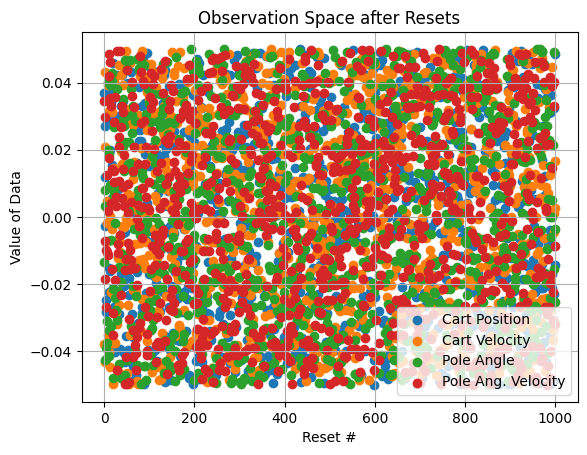

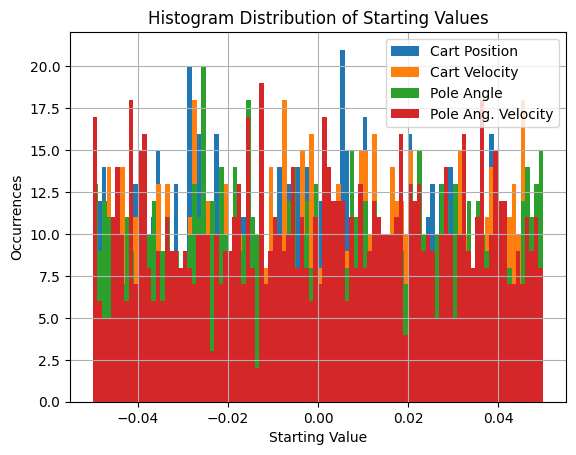

In [86]:
# First show the Reset Functionality
print("Showing .reset() functionality")
state = env.reset()
print(state)
print("")
resets = 1000
print(f"Run {resets} Resets:")
xs = []
c_pos = []
c_vels = []
p_angs = []
a_vels = []
for i in range(resets):
    state = env.reset()[0]
    if i < 10:
       print(state)
    c_pos.append(state[0])
    c_vels.append(state[1])
    p_angs.append(state[2])
    a_vels.append(state[3])
    xs.append(i)
print("")

plt.scatter(xs, c_pos)
plt.scatter(xs, c_vels)
plt.scatter(xs, p_angs)
plt.scatter(xs, a_vels)

plt.grid()
plt.title("Observation Space after Resets")
plt.xlabel("Reset #")
plt.ylabel("Value of Data")
plt.legend([
    "Cart Position",
    "Cart Velocity",
    "Pole Angle",
    "Pole Ang. Velocity",
])
plt.show()

n_bins = 100
plt.hist(c_pos, bins=n_bins)
# plt.show()
plt.hist(c_vels, bins=n_bins)
# plt.show()
plt.hist(p_angs, bins=n_bins)
# plt.show()
plt.hist(a_vels, bins=n_bins)
plt.grid()
plt.title("Histogram Distribution of Starting Values")
plt.legend([
    "Cart Position",
    "Cart Velocity",
    "Pole Angle",
    "Pole Ang. Velocity",
])
plt.ylabel("Occurrences")
plt.xlabel("Starting Value")
plt.show()


Ok, we can see that calling the .reset() function will start the game over and set the state to when the cart is near the center of the arena and the pole is upright with a minor speed value. 
We can see that after running many resets, there is always a minor random value that is set to each of the items in the observation space. There seems to be a uniform distribution of randomized values for each parameter in the range -.05 to +.05

This helps to avoid overfitting of our model as the starting conditions will always be slightly different.

Showing .step() functionality
(array([-0.80367565, -3.9375675 ,  1.3321071 ,  7.209693  ], dtype=float32), 0.0, True, False, {})

Run 20 Steps with the same action:


c:\Users\Ben\Workspace\CSCA5642Final\venv\lib\site-packages\gym\envs\classic_control\cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


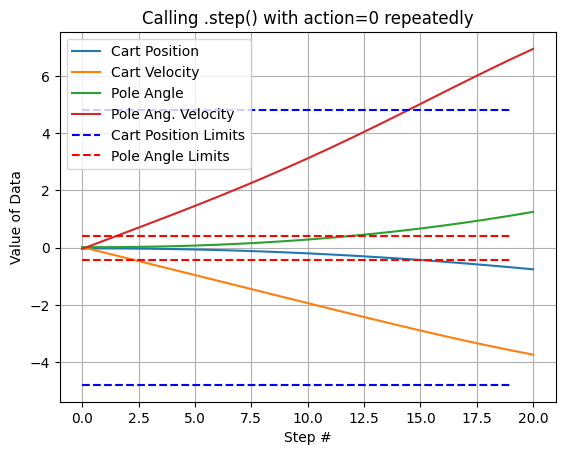

In [ ]:
# Show the step functionality
print("Showing .step() functionality")
response = env.step(0)
print(response)
print("")
steps = 20

print(f"Run {steps} Steps with the same action:")
state = env.reset()
xs = [0]
c_pos = [state[0][0]]
c_vels = [state[0][1]]
p_angs = [state[0][2]]
a_vels = [state[0][3]]
for i in range(steps):
    ans = env.step(0)
    state = ans[0]
    c_pos.append(state[0])
    c_vels.append(state[1])
    p_angs.append(state[2])
    a_vels.append(state[3])
    xs.append(i+1)

c_limit_low_xs = [0, steps-1]
c_limit_low_ys = [-4.8, -4.8]

c_limit_high_xs = [0, steps-1]
c_limit_high_ys = [4.8, 4.8]

pa_limit_low_xs = [0, steps-1]
pa_limit_low_ys = [-.418, -.418]

pa_limit_high_xs = [0, steps-1]
pa_limit_high_ys = [.418, .418]

plt.plot(xs, c_pos)
plt.plot(xs, c_vels)
plt.plot(xs, p_angs)
plt.plot(xs, a_vels)

plt.plot(c_limit_low_xs,c_limit_low_ys, 'b--')
plt.plot(pa_limit_low_xs,pa_limit_low_ys, 'r--')

plt.plot(c_limit_high_xs,c_limit_high_ys, 'b--')
plt.plot(pa_limit_high_xs,pa_limit_high_ys, 'r--')

plt.grid()
plt.title("Calling .step() with action=0 repeatedly")
plt.xlabel("Step #")
plt.ylabel("Value of Data")
plt.legend([
    "Cart Position",
    "Cart Velocity",
    "Pole Angle",
    "Pole Ang. Velocity",
    "Cart Position Limits",
    "Pole Angle Limits"
])
plt.show()

Calling the .step() function repeatedly with the same action gives us insight on how our data is formatted and also how quickly incorrect actions can lead to a failure in the game. The failure in the graph occurs roughly at step 12, when thew Pole Angle crosses the allowed value.

Also it can be noticed that these values do not seem to be similarly scaled. This could be a problem when training our model, so its important to perform some Data Cleaning. Unlike other ML problems, the data is not cleaned at the beginning, and we will need to clean our data on the fly.

### Data Cleaning

To start with cleaning, we can and should normalize our data so everything is in a comparable range. This will help to prevent overfitting, and allow parameters with less extreme values to still hold high importance in the 'mind' of our model.

Its easy to pick the normalization values for the bounded values (the cart position and the pole angle). We simply just scale those values so that all values are between -1 and 1 where the bounds are -1 and 1.

The continuous values of cart speed and pole angular speed are different however. We must pick a value that will become 1 and -1. Based on the 'Runaway' experiment performed above, it looks like both speeds really should not exceed -5 and +5 in normal operation. So we will scale everything for those variables to also be between -1 and 1 where -1 correlates with a speed of -5 and 1 correlates with a speed for both cart speed and pole angular speed.

In [58]:
def normalize_cart_position(cpos):
    """
    Normalize the position of the cart to be between -1 and 1
    """
    return round(cpos/4.8,3)

def normalize_cart_speed(cspeed):
    """
    Normalize the speed of the cart to be betweeen -1 and 1
    """
    return round(cspeed/5, 3)

def normalize_pole_angle(pang):
    """
    Normalize the pole angle of the cart to be betweeen -1 and 1
    """
    return round(pang/.418, 3)

def normalize_pole_angular_velocity(pvel):
    """
    Normalize the pole angle of the cart to be betweeen -1 and 1
    """
    return round(pvel/5, 3)

Actually, the above methods are kind of slow and clunky to apply during training, lets build a single method that uses numpy for speed and has it all in one line.


In [5]:
def normalize_data(state):
    """
    A Faster way to normalize the data
    """    
    normalization_factors = np.array([4.8, 5, .418, 5])
    return state/normalization_factors

Lets test the normalization and show that it scales our data much more reasonably:

Run 20 Steps with the same action:


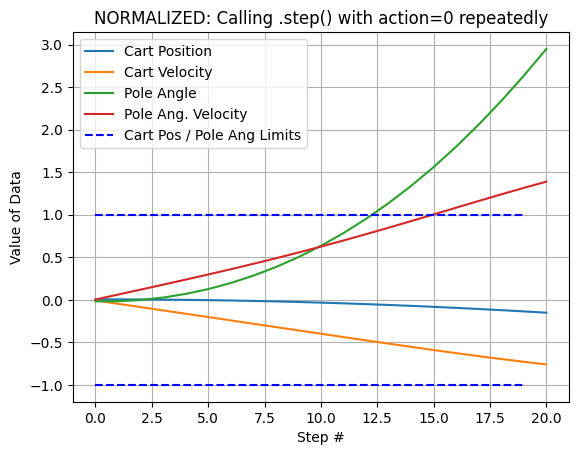

In [70]:
print(f"Run {steps} Steps with the same action:")
state = env.reset()[0]
state = normalize_data(state)
xs = [0]
c_pos = [state[0]]
c_vels = [state[1]]
p_angs = [state[2]]
a_vels = [state[3]]
for i in range(steps):
    ans = env.step(0)
    state = ans[0]
    state = normalize_data(state)
    c_pos.append(state[0])
    c_vels.append(state[1])
    p_angs.append(state[2])
    a_vels.append(state[3])
    xs.append(i+1)

c_limit_low_xs = [0, steps-1]
c_limit_low_ys = [-1, -1]

c_limit_high_xs = [0, steps-1]
c_limit_high_ys = [1, 1]

plt.plot(xs, c_pos)
plt.plot(xs, c_vels)
plt.plot(xs, p_angs)
plt.plot(xs, a_vels)

plt.plot(c_limit_low_xs,c_limit_low_ys, 'b--')
plt.plot(c_limit_high_xs,c_limit_high_ys, 'b--')

plt.grid()
plt.title("NORMALIZED: Calling .step() with action=0 repeatedly")
plt.xlabel("Step #")
plt.ylabel("Value of Data")
plt.legend([
    "Cart Position",
    "Cart Velocity",
    "Pole Angle",
    "Pole Ang. Velocity",
    "Cart Pos / Pole Ang Limits",
])
plt.show()

Nice, the data looks to be much nicer scaled relative to each other than before normalization. This concludes all of the data cleaning that needs to happen for this project. Since this is a simulation, we do not need to worry about any missing values or problematic values as the simulation will only return valid numbers. Due to the nature of the simulation, outlier values are not possible.

If it is noticed that the speeds exceed -1 or +1 at some point during training these values for normalization for the speeds may need to be adjusted.

### Note on importance of observations

From basic analysis, it seems like all of the observation data will be critically important to train a good model. If there were no bounds on the cart's position, then it would be likely that only cart velocity, pole angle, and pole angular velocity would be important for the model to learn from, but since there is bounds on the motion, then the model must understand the cart position as well.

## Model Building

Before we can begin training, it makes sense to set up a class to contain all of our variables, hyperparameters, methods, etc. This will be used by all experiments in this project.

In [ ]:
class CartPoleTrainer():
    """
    Class to contain CartPole Methods neccessary to train cartpole
    """

    def __init__(self, model_name, model = None):
        """
        Set up the class
        """
        self.env = gym.make("CartPole-v1")
        self._define_constants()

        self.model_name = model_name
        self.model = model

    def _define_constants(self):
        """
        Define Constants, variables
        """
        RANDOM_SEED = 23
        np.random.seed(RANDOM_SEED)
        random.seed(RANDOM_SEED)

        self.N_EPISODES = 1000
        self.MIN_EPSILON = .001
        self.EPSILON_DECAY_RATE = .999
        self.epsilon = 1

        self.BATCH_SIZE = 128
        self.GAMMA = .99

        # Memory
        self.memory = []
        self.MAX_MEMORY_SIZE = 2000
        self.MIN_MEMORY_SIZE = 1000

        self.N_STATES = self.env.observation_space.shape[0]
        
    def perform_action(self, state):
        """
        Go ahead and take action, this requires a model first to use
        """
        if np.random.rand() <= self.epsilon:
            # Exploring
            return self.env.action_space.sample()
        else:
            # Going with Model's best guess so far
            q_values = self.model.predict(state, verbose=0)
            return np.argmax(q_values[0])
        
    def perform_pure_action(self, state):
        """
        Force predict, no exploring
        """
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def perform_step(self, action):
        """
        Placing this method here to maximize code re-use
        Just parses the step response
        """
        ans = self.env.step(action)
        next_state = np.reshape(ans[0], [1, self.N_STATES])
        reward = ans[1]
        stop_condition = ans[2]
        return next_state, reward, stop_condition

    def decay_epsilon(self):
        """
        Decay the Epsilon Value
        """
        self.epsilon = round(max(self.epsilon * self.EPSILON_DECAY_RATE, self.MIN_EPSILON),4)
    
    def store_experience_to_memory(self, state, action, reward, next_state, stop_condition):
        """
        Store experiences into memory for recall and use in batch training later
        """
        
        self.memory.append((
            state,
            action,
            reward,
            next_state,
            stop_condition,
        ))

        # Keep the memory under the maximum size
        if len(self.memory) > self.MAX_MEMORY_SIZE:
            self.memory.pop(0)
        
    def learn_by_batch(self):
        """
        Pull experiences from the memory and apply learning
        """
        if len(self.memory) < self.BATCH_SIZE:
            # There are not enough datas to learn from yet
            print("There are not yet enough samples to learn from")
            return
        
        # print("Initiating Batch Learning")
        batch = random.sample(self.memory, self.BATCH_SIZE)

        states = np.zeros((self.BATCH_SIZE, self.N_STATES))
        next_states = np.zeros((self.BATCH_SIZE, self.N_STATES))
        
        actions = []
        rewards = []
        stop_conditions = []

        for iter, memory_slice in enumerate(batch):
            states[iter] = memory_slice[0][0]
            actions.append(memory_slice[1])
            rewards.append(memory_slice[2])
            next_states[iter] = memory_slice[3][0]
            stop_conditions.append(memory_slice[4])

        q_values = self.model.predict(states, verbose=0)
        q_values_next = self.model.predict(next_states, verbose = 0)
    
        for i in range(len(states)):
            if stop_conditions[i] == True:
                q_values[i][actions[i]] = rewards[i]

            else:
                # Bellman equation
                q_values[i][actions[i]] = rewards[i] + self.GAMMA * (np.amax(q_values_next[i]))

        # Fit the model given the new desired outcome
        self.model.fit(states, q_values, verbose = 0)

    def evaluate(self):
        """
        Perform an evaluation of the model at a certain milestone
        """
        total_rewards = []
        for i in range(10):
            state = self.env.reset()
            state = normalize_data(np.reshape(state[0], [1,self.N_STATES]))

            total_reward = 0

            stop_condition = False
            while stop_condition is not True:
                action = self.perform_pure_action(state)
                next_state, reward, stop_condition = self.perform_step(action)

                state = next_state
                total_reward += reward

            total_rewards.append(total_reward)

        result = round(sum(total_rewards)/20,2)

        print("Evaluation of Model at Milestone: {}".format(result))

        return result

    def main_loop(self):
        episodes = []
        total_rewards = []
        epsilons = []
        evaluation_episodes = []
        evaluations = []

        print("========================================")
        print("Performing Initial Memory Population")
        while len(self.memory) < self.MIN_MEMORY_SIZE:
            state = self.env.reset()
            state = normalize_data(np.reshape(state[0], [1,self.N_STATES]))
            stop_condition = False

            while stop_condition is not True:
                action = self.env.action_space.sample() # take random action
                next_state, reward, stop_condition = self.perform_step(action)
                next_state = normalize_data(next_state)
                self.store_experience_to_memory(state, action, reward, next_state, stop_condition)
                state = next_state

        print("Finished Initial Memory Population")
        print("========================================")
        print("")

        print("========================================")
        print("Beginning Training Loop")
        win_condition = False
        for episode in range(self.N_EPISODES):
            state = self.env.reset()
            state = normalize_data(np.reshape(state[0], [1,self.N_STATES]))

            total_reward = 0

            stop_condition = False
            while stop_condition is not True:
                action = self.perform_action(state)
                next_state, reward, stop_condition = self.perform_step(action)
                next_state = normalize_data(next_state)
                self.store_experience_to_memory(state, action, reward, next_state, stop_condition)

                state = next_state
                total_reward += reward

                self.learn_by_batch()
                self.decay_epsilon()

                if total_reward > 475:
                    # We win
                    win_condition = True
                    break

            print("Episode {}, Reward: {}, Epsilon: {}".format(episode, int(total_reward), self.epsilon))

            episodes.append(episode)
            total_rewards.append(total_reward)
            epsilons.append(self.epsilon)

            if win_condition:
                print("Model Success! Win Condition Reached")
                break

            if episode % 10 == 0:
                # Evaluate the model
                evalu = self.evaluate()
                evaluation_episodes.append(episode)
                evaluations.append(evalu)

        print("========================================")
        print("")
    
        return episodes, total_rewards, epsilons, evaluation_episodes, evaluations

In [13]:
# Useful Method to save model results, even if the kernel crashes
import pickle

def save_results_to_pickle(name, episodes, total_rewards, epsilons, evaluation_episodes, evaluations):
    d = {}
    d["episodes"] = episodes
    d["total_rewards"] = total_rewards
    d["epsilons"] = epsilons
    d["evaluation_episodes"] = evaluation_episodes
    d["evaluations"] = evaluations
    
    filename = name + "_results.pkl"

    with open(filename, "wb") as f:
        pickle.dump(d, f)


def load_results_from_pickle(name, ):
    filename = name + "_results.pkl"

    with open(filename, "rb") as f:
        d = pickle.load(f)

    episodes = d["episodes"]
    total_rewards = d["total_rewards"]
    epsilons = d["epsilons"]
    evaluation_episodes = d["evaluation_episodes"]
    evaluations = d["evaluations"]
    
    return episodes, total_rewards, epsilons, evaluation_episodes, evaluations

def load_results_from_pickle_dict(name, ):
    filename = name + "_results.pkl"

    with open(filename, "rb") as f:
        d = pickle.load(f)

    return d

def save_class_to_pickle(name, your_class):
    filename = name + "_class.pkl"

    with open(filename, "wb") as f:
        pickle.dump(your_class, f)

def load_class_from_pickle(name, your_class):
    filename = name + "_class.pkl"

    with open(filename, "wb") as f:
        your_class = pickle.load(f)
    return your_class


In [ ]:
# Useful Plotting Methods

def plot_results(
    name,
    episodes,
    rews,
    epsilons,
    eval_epis,
    evals,
):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 

    axes[0].plot(episodes, rews, color='blue')
    axes[0].set_title("Rewards per Episode (w/ Exploration)")
    axes[0].set_xlabel("Episodes")
    axes[0].set_ylabel("Reward Earned")
    axes[0].grid()

    axes[1].plot(episodes, epsilons, color='red')
    axes[1].set_title("Epsilon value per Episode")
    axes[1].set_xlabel("Episodes")
    axes[1].set_ylabel("Epsilon Value")
    axes[1].grid()

    axes[2].plot(eval_epis, evals, color='green')
    axes[2].set_title("Milestone Evaluation Scores")
    axes[2].set_xlabel("Episodes")
    axes[2].set_ylabel("Evaluation Score")
    axes[2].grid()

    fig.suptitle(f"{name}-Model Results")
    plt.tight_layout()
    plt.show()


def plot_experiment_3(mvp, medium, large, exp_num, custom_legend):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].plot(mvp["episodes"], mvp["total_rewards"], color='blue')
    axes[0].plot(medium["episodes"], medium["total_rewards"], color='red')
    axes[0].plot(large["episodes"], large["total_rewards"], color='green')
    axes[0].legend(custom_legend)
    axes[0].set_title("Rewards per Episode (w/ Exploration)")
    axes[0].set_xlabel("Episodes")
    axes[0].set_ylabel("Reward Earned")
    axes[0].grid()

    axes[1].plot(mvp["episodes"], mvp["epsilons"], color='blue')
    axes[1].plot(medium["episodes"], medium["epsilons"], color='red')
    axes[1].plot(large["episodes"], large["epsilons"], color='green')
    axes[1].legend(custom_legend)
    axes[1].set_title("Epsilon value per Episode")
    axes[1].set_xlabel("Episodes")
    axes[1].set_ylabel("Epsilon Value")
    axes[1].grid()

    axes[2].plot(mvp["evaluation_episodes"], mvp["evaluations"], color='blue')
    axes[2].plot(medium["evaluation_episodes"], medium["evaluations"], color='red')
    axes[2].plot(large["evaluation_episodes"], large["evaluations"], color='green')
    axes[2].legend(custom_legend)
    axes[2].set_title("Milestone Evaluation Scores")
    axes[2].set_xlabel("Episodes")
    axes[2].set_ylabel("Evaluation Score")
    axes[2].grid()

    fig.suptitle(f"Experiment {exp_num} Results")

    plt.tight_layout()
    plt.show()


def plot_experiment_2(mvp, medium, exp_num, custom_legend):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].plot(mvp["episodes"], mvp["total_rewards"], color='blue')
    axes[0].plot(medium["episodes"], medium["total_rewards"], color='red')
    axes[0].legend(custom_legend)
    axes[0].set_title("Rewards per Episode (w/ Exploration)")
    axes[0].set_xlabel("Episodes")
    axes[0].set_ylabel("Reward Earned")
    axes[0].grid()

    axes[1].plot(mvp["episodes"], mvp["epsilons"], color='blue')
    axes[1].plot(medium["episodes"], medium["epsilons"], color='red')
    axes[1].legend(custom_legend)
    axes[1].set_title("Epsilon value per Episode")
    axes[1].set_xlabel("Episodes")
    axes[1].set_ylabel("Epsilon Value")
    axes[1].grid()

    axes[2].plot(mvp["evaluation_episodes"], mvp["evaluations"], color='blue')
    axes[2].plot(medium["evaluation_episodes"], medium["evaluations"], color='red')
    axes[2].legend(custom_legend)
    axes[2].set_title("Milestone Evaluation Scores")
    axes[2].set_xlabel("Episodes")
    axes[2].set_ylabel("Evaluation Score")
    axes[2].grid()

    fig.suptitle(f"Experiment {exp_num} Results")

    plt.tight_layout()
    plt.show()


### Build MVP

Lets kick off our project by building a minimum viable product and see how it performs

In [30]:
LEARNING_RATE = .001
model_mvp_name = 'mvp'
model_mvp = Sequential()
model_mvp.add(Dense(4, input_dim = N_STATES, activation = 'relu'))
model_mvp.add(Dense(8, activation = 'relu'))
model_mvp.add(Dense(N_ACTIONS, activation = 'linear'))

optimizer = Adam(learning_rate = LEARNING_RATE) 

model_mvp.compile(
    loss='mse',
    optimizer = optimizer)

model_mvp.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 4)                 20        
                                                                 
 dense_18 (Dense)            (None, 8)                 40        
                                                                 
 dense_19 (Dense)            (None, 2)                 18        
                                                                 
Total params: 78
Trainable params: 78
Non-trainable params: 0
_________________________________________________________________


In [31]:
mvp_trainer = CartPoleTrainer(model_mvp_name, model_mvp)
mvp_trainer.N_EPISODES = 100
mvp_episodes, mvp_total_rewards, mvp_epsilons, mvp_evaluation_episodes, mvp_evaluations = mvp_trainer.main_loop()

Performing Initial Memory Population
Finished Initial Memory Population

Beginning Training Loop


c:\Users\Ben\Workspace\CSCA5642Final\venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0, Reward: 18, Epsilon: 0.982
Evaluation of Model at Milestone: 25.75
Episode 1, Reward: 17, Epsilon: 0.965
Episode 2, Reward: 25, Epsilon: 0.9409
Episode 3, Reward: 15, Epsilon: 0.9274
Episode 4, Reward: 12, Epsilon: 0.9166
Episode 5, Reward: 22, Epsilon: 0.8968
Episode 6, Reward: 13, Epsilon: 0.8851
Episode 7, Reward: 29, Epsilon: 0.859
Episode 8, Reward: 23, Epsilon: 0.8395
Episode 9, Reward: 73, Epsilon: 0.7811
Episode 10, Reward: 18, Epsilon: 0.7667
Evaluation of Model at Milestone: 4.65
Episode 11, Reward: 17, Epsilon: 0.7531
Episode 12, Reward: 28, Epsilon: 0.7331
Episode 13, Reward: 13, Epsilon: 0.724
Episode 14, Reward: 25, Epsilon: 0.7065
Episode 15, Reward: 11, Epsilon: 0.6988
Episode 16, Reward: 42, Epsilon: 0.6694
Episode 17, Reward: 9, Epsilon: 0.6631
Episode 18, Reward: 31, Epsilon: 0.6426
Episode 19, Reward: 13, Epsilon: 0.6348
Episode 20, Reward: 17, Epsilon: 0.6246
Evaluation of Model at Milestone: 4.6
Episode 21, Reward: 11, Epsilon: 0.618
Episode 22, Reward:

In [32]:
save_results_to_pickle("mvp", mvp_episodes, mvp_total_rewards, mvp_epsilons, mvp_evaluation_episodes, mvp_evaluations)

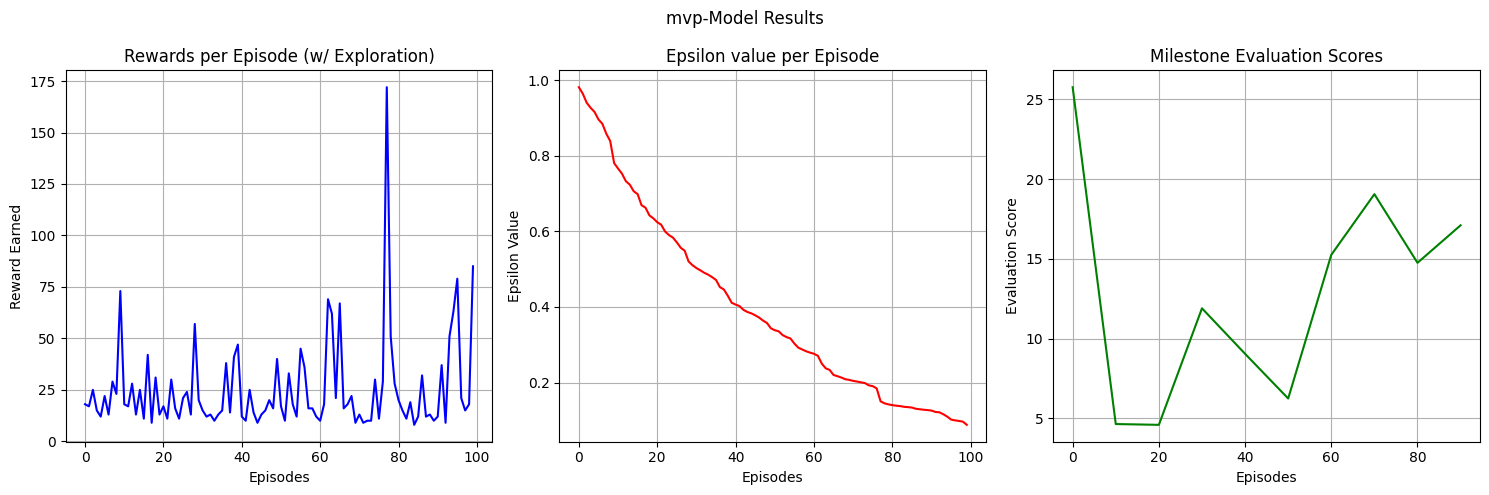

In [16]:
mvp_episodes, mvp_total_rewards, mvp_epsilons, mvp_evaluation_episodes, mvp_evaluations = load_results_from_pickle('mvp')
plot_results("mvp", mvp_episodes, mvp_total_rewards, mvp_epsilons, mvp_evaluation_episodes, mvp_evaluations)

### Experiment 1 : Different Model Architectures

Lets experiment with different model architectures and see if we can reach convergence faster.

Lets build a Medium and Large NN, and compare this against the original MVP

In [8]:
LEARNING_RATE = .001
model_medium_name = 'medium'
model_medium = Sequential()
model_medium.add(Dense(64, input_dim = N_STATES, activation = 'relu'))
model_medium.add(Dense(32, activation = 'relu'))
model_medium.add(Dense(16, activation = 'relu'))
model_medium.add(Dense(N_ACTIONS, activation = 'linear'))

optimizer = Adam(learning_rate = LEARNING_RATE) 

model_medium.compile(
    loss='mse',
    optimizer = optimizer)

In [9]:
medium_trainer = CartPoleTrainer(model_medium_name, model_medium)
medium_trainer.N_EPISODES = 100
medium_episodes, medium_total_rewards, medium_epsilons, medium_evaluation_episodes, medium_evaluations = medium_trainer.main_loop()

Performing Initial Memory Population
Finished Initial Memory Population

Beginning Training Loop


c:\Users\Ben\Workspace\CSCA5642Final\venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0, Reward: 11, Epsilon: 0.989
Evaluation of Model at Milestone: 9.25
Episode 1, Reward: 35, Epsilon: 0.954
Episode 2, Reward: 13, Epsilon: 0.9418
Episode 3, Reward: 20, Epsilon: 0.9238
Episode 4, Reward: 29, Epsilon: 0.8977
Episode 5, Reward: 14, Epsilon: 0.8851
Episode 6, Reward: 20, Epsilon: 0.8671
Episode 7, Reward: 10, Epsilon: 0.8581
Episode 8, Reward: 17, Epsilon: 0.8435
Episode 9, Reward: 30, Epsilon: 0.8195
Episode 10, Reward: 33, Epsilon: 0.7931
Evaluation of Model at Milestone: 9.5
Episode 11, Reward: 35, Epsilon: 0.7651
Episode 12, Reward: 11, Epsilon: 0.7563
Episode 13, Reward: 24, Epsilon: 0.7387
Episode 14, Reward: 37, Epsilon: 0.7128
Episode 15, Reward: 38, Epsilon: 0.6862
Episode 16, Reward: 20, Epsilon: 0.6722
Episode 17, Reward: 147, Epsilon: 0.5808
Episode 18, Reward: 29, Epsilon: 0.5634
Episode 19, Reward: 113, Epsilon: 0.5046
Episode 20, Reward: 38, Epsilon: 0.4856
Evaluation of Model at Milestone: 111.9
Episode 21, Reward: 42, Epsilon: 0.4646
Episode 22, R

In [19]:
# save_class_to_pickle("medium", medium_trainer)
save_results_to_pickle("medium", medium_episodes, medium_total_rewards, medium_epsilons, medium_evaluation_episodes, medium_evaluations)

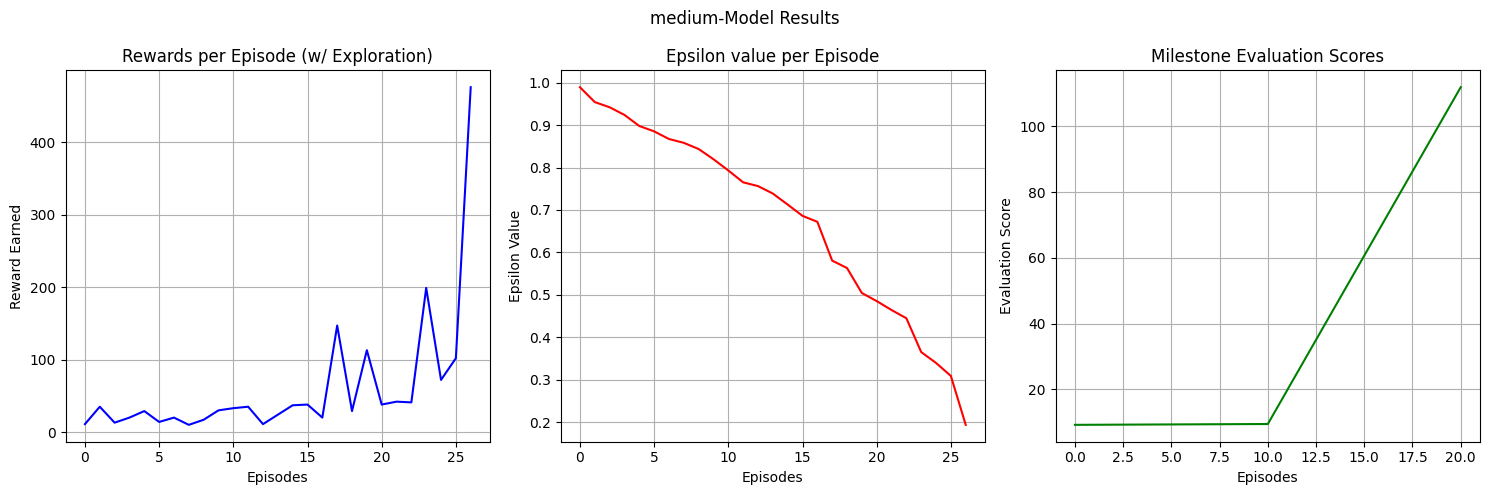

In [17]:
medium_episodes, medium_total_rewards, medium_epsilons, medium_evaluation_episodes, medium_evaluations = load_results_from_pickle('medium')
plot_results("medium", medium_episodes, medium_total_rewards, medium_epsilons, medium_evaluation_episodes, medium_evaluations)

In [10]:
LEARNING_RATE = .001
model_large_name = 'large'
model_large = Sequential()
model_large.add(Dense(256, input_dim = N_STATES, activation = 'relu'))
model_large.add(Dense(128, activation = 'relu'))
model_large.add(Dense(64, activation = 'relu'))
model_large.add(Dense(N_ACTIONS, activation = 'linear'))

optimizer = Adam(learning_rate = LEARNING_RATE) 

model_large.compile(
    loss='mse',
    optimizer = optimizer)

In [11]:
large_trainer = CartPoleTrainer(model_large_name, model_large)
large_trainer.N_EPISODES = 100
large_episodes, large_total_rewards, large_epsilons, large_evaluation_episodes, large_evaluations = large_trainer.main_loop()

Performing Initial Memory Population
Finished Initial Memory Population

Beginning Training Loop
Episode 0, Reward: 38, Epsilon: 0.962
Evaluation of Model at Milestone: 9.35
Episode 1, Reward: 24, Epsilon: 0.9391
Episode 2, Reward: 17, Epsilon: 0.9238
Episode 3, Reward: 18, Epsilon: 0.9076
Episode 4, Reward: 12, Epsilon: 0.8968
Episode 5, Reward: 18, Epsilon: 0.8806
Episode 6, Reward: 13, Epsilon: 0.8689
Episode 7, Reward: 36, Epsilon: 0.8379
Episode 8, Reward: 14, Epsilon: 0.8267
Episode 9, Reward: 48, Epsilon: 0.7883
Episode 10, Reward: 10, Epsilon: 0.7803
Evaluation of Model at Milestone: 9.25
Episode 11, Reward: 104, Epsilon: 0.7037
Episode 12, Reward: 29, Epsilon: 0.6834
Episode 13, Reward: 36, Epsilon: 0.6582
Episode 14, Reward: 16, Epsilon: 0.6474
Episode 15, Reward: 15, Epsilon: 0.6384
Episode 16, Reward: 155, Epsilon: 0.5461
Episode 17, Reward: 20, Epsilon: 0.5361
Episode 18, Reward: 42, Epsilon: 0.5151
Episode 19, Reward: 150, Epsilon: 0.442
Episode 20, Reward: 19, Epsilon: 0

In [20]:
save_results_to_pickle("large", large_episodes, large_total_rewards, large_epsilons, large_evaluation_episodes, large_evaluations)

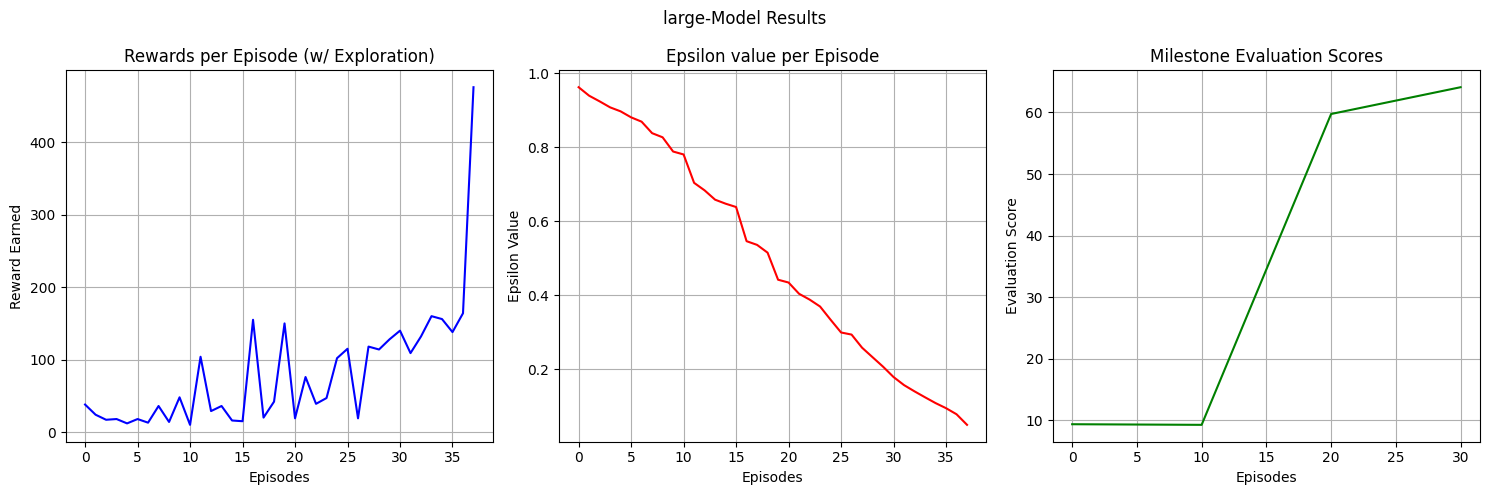

In [18]:
large_episodes, large_total_rewards, large_epsilons, large_evaluation_episodes, large_evaluations = load_results_from_pickle('large')
plot_results("large", large_episodes, large_total_rewards, large_epsilons, large_evaluation_episodes, large_evaluations)

### Experiment 2: Tune the Learning Rate Hyperparameter

Ok, next, lets test a few different learning rates to see if we can converge faster

In [12]:
LEARNING_RATE = .0001
model_slow_name = 'slow'
model_slow = Sequential()
model_slow.add(Dense(4, input_dim = N_STATES, activation = 'relu'))
model_slow.add(Dense(8, activation = 'relu'))
model_slow.add(Dense(N_ACTIONS, activation = 'linear'))

optimizer = Adam(learning_rate = LEARNING_RATE) 

model_slow.compile(
    loss='mse',
    optimizer = optimizer)

model_slow.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 4)                 20        
                                                                 
 dense_9 (Dense)             (None, 8)                 40        
                                                                 
 dense_10 (Dense)            (None, 2)                 18        
                                                                 
Total params: 78
Trainable params: 78
Non-trainable params: 0
_________________________________________________________________


In [13]:
slow_trainer = CartPoleTrainer(model_slow_name, model_slow)
slow_trainer.N_EPISODES = 100
slow_episodes, slow_total_rewards, slow_epsilons, slow_evaluation_episodes, slow_evaluations = slow_trainer.main_loop()

Performing Initial Memory Population
Finished Initial Memory Population

Beginning Training Loop
Episode 0, Reward: 20, Epsilon: 0.98
Evaluation of Model at Milestone: 11.2
Episode 1, Reward: 26, Epsilon: 0.954
Episode 2, Reward: 18, Epsilon: 0.9373
Episode 3, Reward: 20, Epsilon: 0.9193
Episode 4, Reward: 14, Epsilon: 0.9067
Episode 5, Reward: 23, Epsilon: 0.886
Episode 6, Reward: 10, Epsilon: 0.877
Episode 7, Reward: 18, Epsilon: 0.8608
Episode 8, Reward: 14, Epsilon: 0.8483
Episode 9, Reward: 11, Epsilon: 0.8395
Episode 10, Reward: 16, Epsilon: 0.8267
Evaluation of Model at Milestone: 9.1
Episode 11, Reward: 14, Epsilon: 0.8155
Episode 12, Reward: 23, Epsilon: 0.7971
Episode 13, Reward: 15, Epsilon: 0.7851
Episode 14, Reward: 11, Epsilon: 0.7763
Episode 15, Reward: 9, Epsilon: 0.7691
Episode 16, Reward: 34, Epsilon: 0.7429
Episode 17, Reward: 14, Epsilon: 0.7331
Episode 18, Reward: 49, Epsilon: 0.6988
Episode 19, Reward: 18, Epsilon: 0.6862
Episode 20, Reward: 28, Epsilon: 0.6666
Ev

In [22]:
save_results_to_pickle("slow", slow_episodes, slow_total_rewards, slow_epsilons, slow_evaluation_episodes, slow_evaluations)

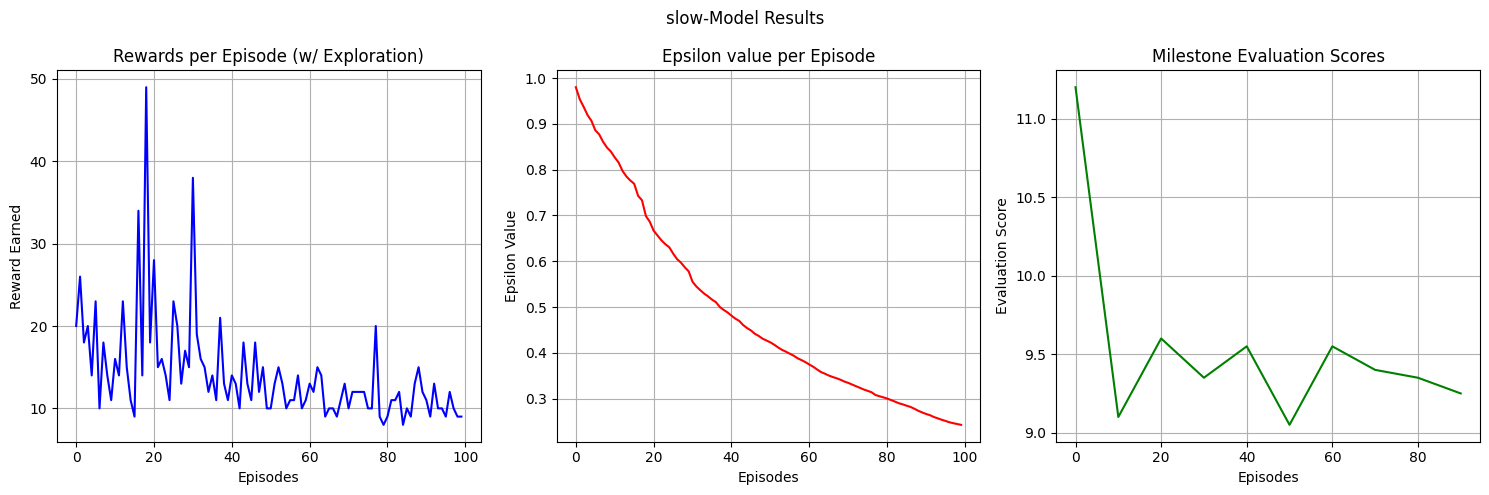

In [19]:
slow_episodes, slow_total_rewards, slow_epsilons, slow_evaluation_episodes, slow_evaluations = load_results_from_pickle('slow')
plot_results("slow", slow_episodes, slow_total_rewards, slow_epsilons, slow_evaluation_episodes, slow_evaluations)

In [23]:
LEARNING_RATE = .01
model_fast_name = 'fast'
model_fast = Sequential()
model_fast.add(Dense(4, input_dim = N_STATES, activation = 'relu'))
model_fast.add(Dense(8, activation = 'relu'))
model_fast.add(Dense(N_ACTIONS, activation = 'linear'))

optimizer = Adam(learning_rate = LEARNING_RATE) 

model_fast.compile(
    loss='mse',
    optimizer = optimizer)

model_fast.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 4)                 20        
                                                                 
 dense_12 (Dense)            (None, 8)                 40        
                                                                 
 dense_13 (Dense)            (None, 2)                 18        
                                                                 
Total params: 78
Trainable params: 78
Non-trainable params: 0
_________________________________________________________________


In [24]:
fast_trainer = CartPoleTrainer(model_fast_name, model_fast)
fast_trainer.N_EPISODES = 100
fast_episodes, fast_total_rewards, fast_epsilons, fast_evaluation_episodes, fast_evaluations = fast_trainer.main_loop()

Performing Initial Memory Population
Finished Initial Memory Population

Beginning Training Loop


c:\Users\Ben\Workspace\CSCA5642Final\venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0, Reward: 22, Epsilon: 0.978
Evaluation of Model at Milestone: 4.55
Episode 1, Reward: 38, Epsilon: 0.9409
Episode 2, Reward: 22, Epsilon: 0.9211
Episode 3, Reward: 20, Epsilon: 0.9031
Episode 4, Reward: 12, Epsilon: 0.8923
Episode 5, Reward: 24, Epsilon: 0.8707
Episode 6, Reward: 15, Epsilon: 0.8572
Episode 7, Reward: 15, Epsilon: 0.8443
Episode 8, Reward: 13, Epsilon: 0.8339
Episode 9, Reward: 17, Epsilon: 0.8203
Episode 10, Reward: 13, Epsilon: 0.8099
Evaluation of Model at Milestone: 4.7
Episode 11, Reward: 49, Epsilon: 0.7707
Episode 12, Reward: 28, Epsilon: 0.7485
Episode 13, Reward: 16, Epsilon: 0.7373
Episode 14, Reward: 41, Epsilon: 0.7086
Episode 15, Reward: 11, Epsilon: 0.7009
Episode 16, Reward: 14, Epsilon: 0.6911
Episode 17, Reward: 11, Epsilon: 0.6834
Episode 18, Reward: 24, Epsilon: 0.6666
Episode 19, Reward: 12, Epsilon: 0.6582
Episode 20, Reward: 29, Epsilon: 0.6396
Evaluation of Model at Milestone: 4.7
Episode 21, Reward: 11, Epsilon: 0.633
Episode 22, Rewar

In [25]:
save_results_to_pickle("fast", fast_episodes, fast_total_rewards, fast_epsilons, fast_evaluation_episodes, fast_evaluations)

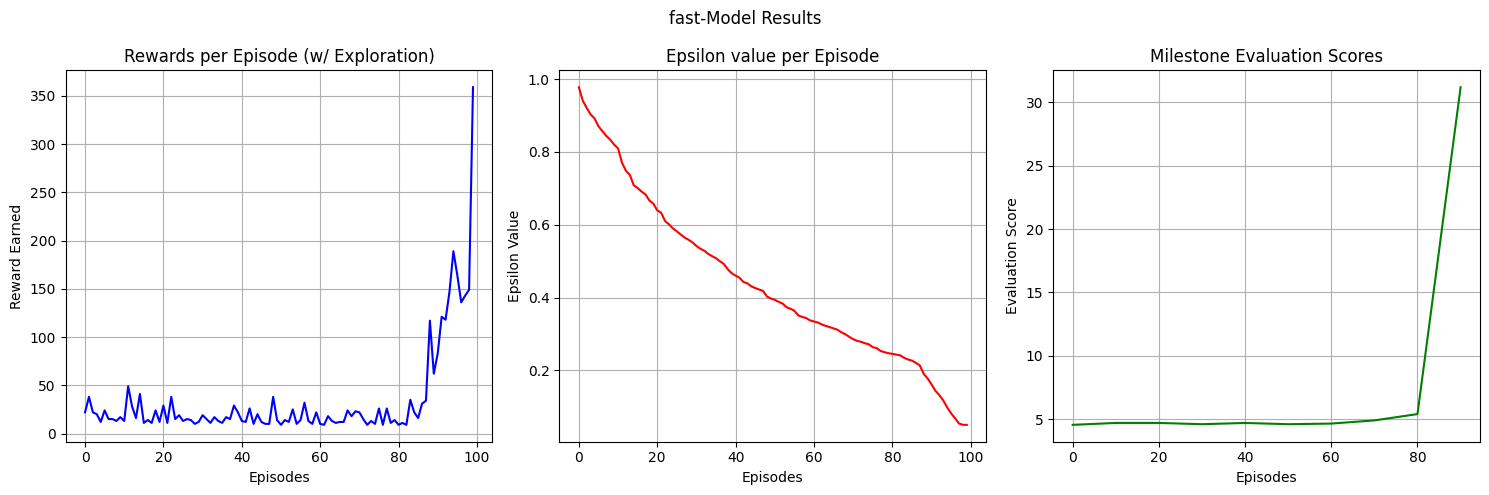

In [20]:
fast_episodes, fast_total_rewards, fast_epsilons, fast_evaluation_episodes, fast_evaluations = load_results_from_pickle('fast')
plot_results("fast", fast_episodes, fast_total_rewards, fast_epsilons, fast_evaluation_episodes, fast_evaluations)

### Experiment 3: Alter the way rewards are given

Try: +.1 point for every extra point earned

Theory: This will further incentivize later scores, encouraging the models to last longer and therefore get a higher score.

In [8]:
LEARNING_RATE = .001
model_rew1_name = 'rew1'
model_rew1 = Sequential()
model_rew1.add(Dense(4, input_dim = N_STATES, activation = 'relu'))
model_rew1.add(Dense(8, activation = 'relu'))
model_rew1.add(Dense(N_ACTIONS, activation = 'linear'))

optimizer = Adam(learning_rate = LEARNING_RATE) 

model_rew1.compile(
    loss='mse',
    optimizer = optimizer)

model_rew1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 8)                 40        
                                                                 
 dense_2 (Dense)             (None, 2)                 18        
                                                                 
Total params: 78
Trainable params: 78
Non-trainable params: 0
_________________________________________________________________


In [10]:
rew1_trainer = CartPoleTrainer(model_rew1_name, model_rew1)

def rew1_loop(self):
    episodes = []
    total_rewards = []
    epsilons = []
    evaluation_episodes = []
    evaluations = []

    print("========================================")
    print("Performing Initial Memory Population")
    while len(self.memory) < self.MIN_MEMORY_SIZE:
        state = self.env.reset()
        state = normalize_data(np.reshape(state[0], [1,self.N_STATES]))
        stop_condition = False

        steps = 0
        while stop_condition is not True:
            action = self.env.action_space.sample() # take random action
            next_state, reward, stop_condition = self.perform_step(action)
            next_state = normalize_data(next_state)
            mod_reward = reward + (.1*steps)    
            self.store_experience_to_memory(state, action, mod_reward, next_state, stop_condition)
            state = next_state
            steps+=1

    print("Finished Initial Memory Population")
    print("========================================")
    print("")

    print("========================================")
    print("Beginning Training Loop")
    win_condition = False
    for episode in range(self.N_EPISODES):
        state = self.env.reset()
        state = normalize_data(np.reshape(state[0], [1,self.N_STATES]))

        total_reward = 0

        stop_condition = False
        steps = 0
        while stop_condition is not True:
            action = self.perform_action(state)
            next_state, reward, stop_condition = self.perform_step(action)
            next_state = normalize_data(next_state)
            mod_reward = reward + (.1*steps)
            self.store_experience_to_memory(state, action, mod_reward, next_state, stop_condition)

            state = next_state
            total_reward += reward

            self.learn_by_batch()
            self.decay_epsilon()

            if total_reward > 475:
                # We win
                win_condition = True
                break

            steps+=1

        print("Episode {}, Reward: {}, Epsilon: {}".format(episode, int(total_reward), self.epsilon))

        episodes.append(episode)
        total_rewards.append(total_reward)
        epsilons.append(self.epsilon)

        if win_condition:
            print("Model Success! Win Condition Reached")
            break

        if episode % 10 == 0:
            # Evaluate the model
            evalu = self.evaluate()
            evaluation_episodes.append(episode)
            evaluations.append(evalu)

    print("========================================")
    print("")

    return episodes, total_rewards, epsilons, evaluation_episodes, evaluations

CartPoleTrainer.rew1_loop = rew1_loop
rew1_trainer = CartPoleTrainer(model_rew1_name, model_rew1)

rew1_trainer.N_EPISODES = 100
rew1_episodes, rew1_total_rewards, rew1_epsilons, rew1_evaluation_episodes, rew1_evaluations = rew1_trainer.rew1_loop()

Performing Initial Memory Population
Finished Initial Memory Population

Beginning Training Loop


c:\Users\Ben\Workspace\CSCA5642Final\venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0, Reward: 17, Epsilon: 0.983
Evaluation of Model at Milestone: 37.85
Episode 1, Reward: 19, Epsilon: 0.964
Episode 2, Reward: 10, Epsilon: 0.954
Episode 3, Reward: 31, Epsilon: 0.9256
Episode 4, Reward: 13, Epsilon: 0.9139
Episode 5, Reward: 74, Epsilon: 0.8475
Episode 6, Reward: 26, Epsilon: 0.8267
Episode 7, Reward: 17, Epsilon: 0.8131
Episode 8, Reward: 15, Epsilon: 0.8011
Episode 9, Reward: 34, Epsilon: 0.7739
Episode 10, Reward: 13, Epsilon: 0.7635
Evaluation of Model at Milestone: 24.35
Episode 11, Reward: 51, Epsilon: 0.7261
Episode 12, Reward: 48, Epsilon: 0.6925
Episode 13, Reward: 23, Epsilon: 0.6764
Episode 14, Reward: 25, Epsilon: 0.6589
Episode 15, Reward: 25, Epsilon: 0.6426
Episode 16, Reward: 18, Epsilon: 0.6318
Episode 17, Reward: 24, Epsilon: 0.6174
Episode 18, Reward: 46, Epsilon: 0.5898
Episode 19, Reward: 24, Epsilon: 0.5754
Episode 20, Reward: 62, Epsilon: 0.5401
Evaluation of Model at Milestone: 35.8
Episode 21, Reward: 51, Epsilon: 0.5146
Episode 22, Re

In [21]:
save_results_to_pickle("rew1", rew1_episodes, rew1_total_rewards, rew1_epsilons, rew1_evaluation_episodes, rew1_evaluations)

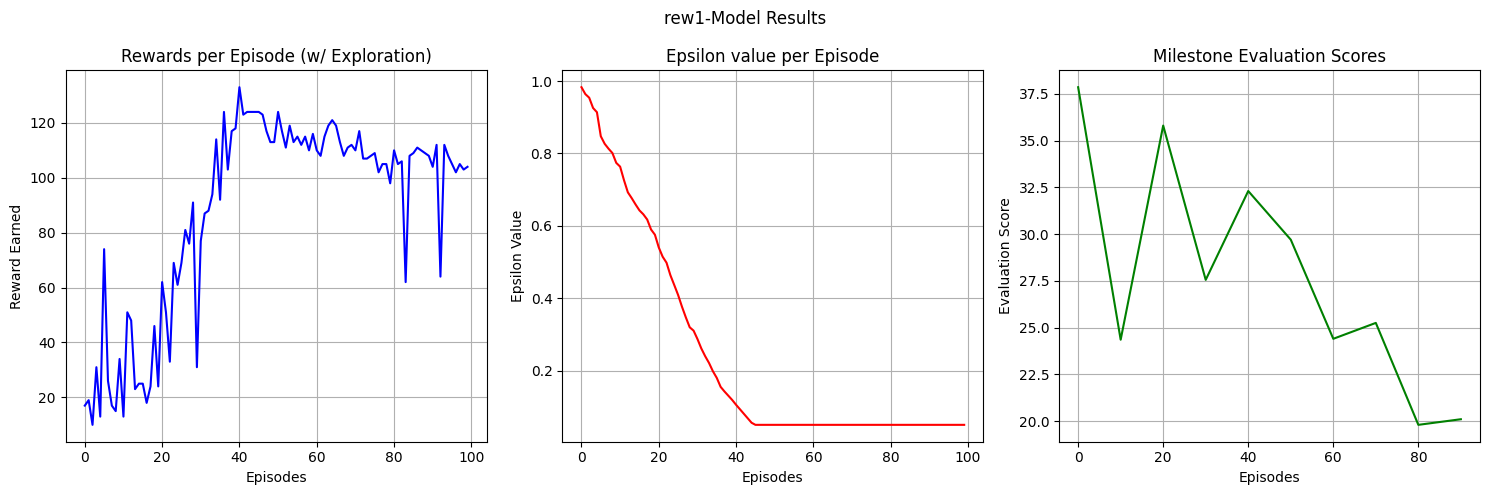

In [22]:
rew1_episodes, rew1_total_rewards, rew1_epsilons, rew1_evaluation_episodes, rew1_evaluations = load_results_from_pickle('rew1')
plot_results("rew1", rew1_episodes, rew1_total_rewards, rew1_epsilons, rew1_evaluation_episodes, rew1_evaluations)

## Results and Analysis

Experiments 1, 2, and 3 were conducted in order to get a better understanding of the capability of Deep Q learning models to solve this type of problem.
- Experiment 1: Try a medium and large sized NN to compare against our MVP
- Experiment 2: Try a faster and slower learning rate and compare against our MVP
- Experiment 3: Try a different way of assigning rewards


Experiment 1 showed that the medium sized architecture was the most appropriate model for this problem.

Experiment 2 showed that the faster learning rate was the best learning rate for this problem.

Experiment 3 showed that the original reward structure was likely the best to eventually win the game, whereas the modified reward structure seemed better to quickly get to higher scores, but worse at sustained growth.

### Summary:

| Model | Win? | Steps Taken | Episodes | Description |
|-|-|-|-|-|
| MVP | No | 2498 | 100 | Minimum Viable Product, just a small model, 4 x 4 x 8 x 4 size NN, learning rate .001|
| Medium | Yes | 1656  | 26 | 4 x 64 x 32 x 16 x 4 size NN|
| Large | Yes | 3067 | 37 | 4 x 256 x 128 x 64 x 4 size NN|
| Slow | No | 3348 | 100 | Slower Learning rate of .0001 |
| Fast | No | 1414 | 100 | Faster Learning rate of .01 |
| Reward Custom | No | 8822 | 100 | Extra reward for consecutive points scored |

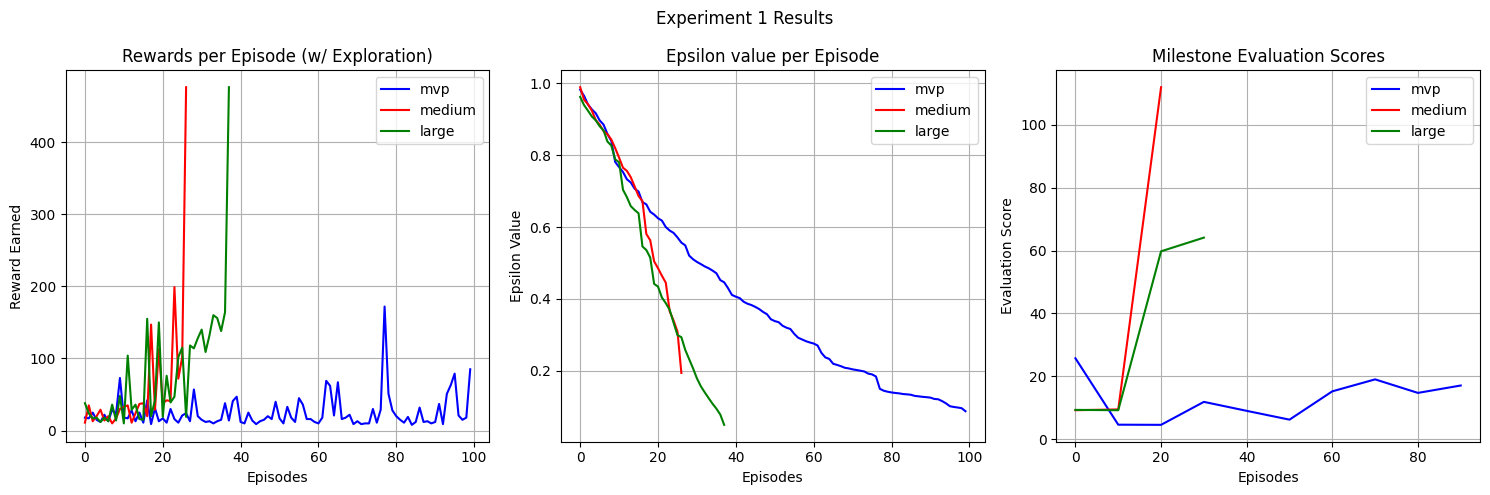

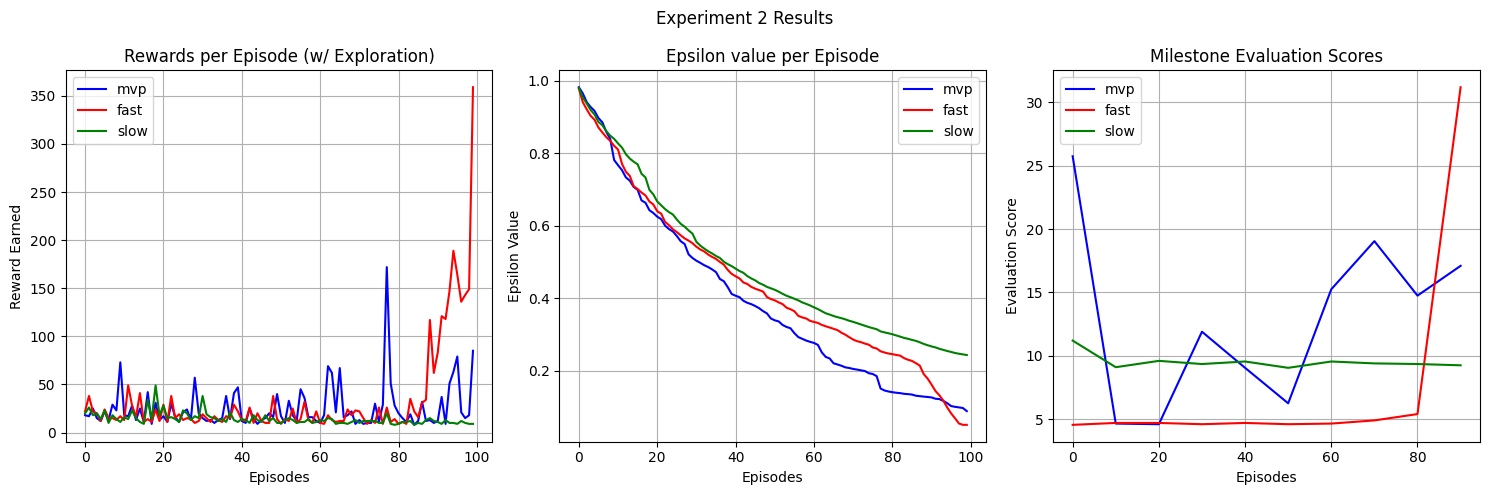

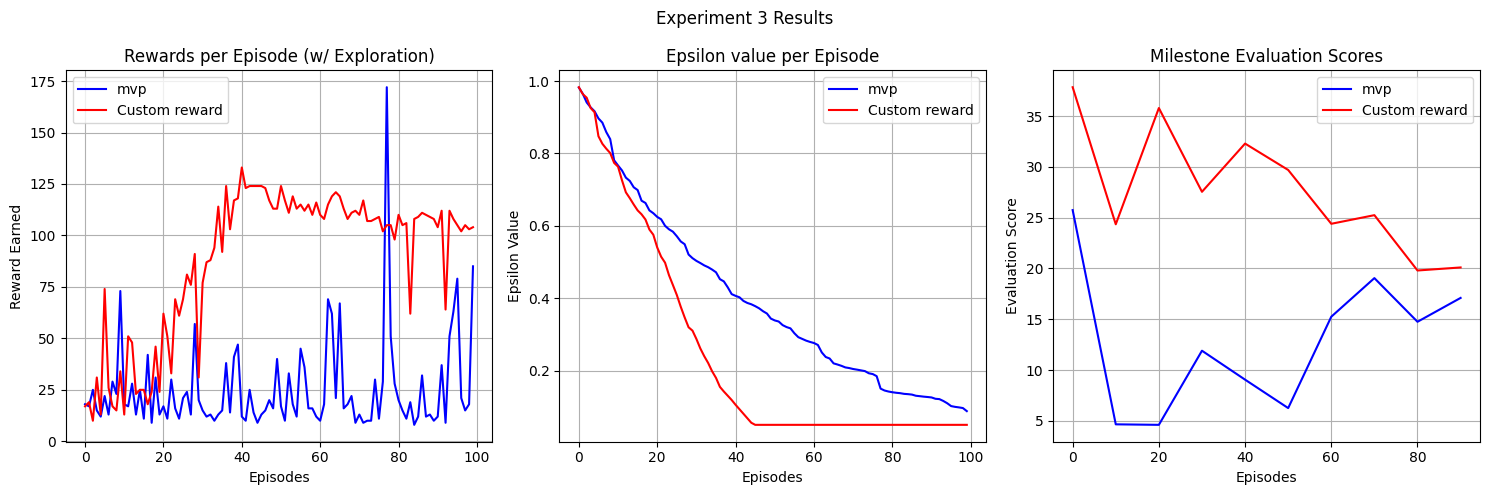

In [28]:
mvp_data = load_results_from_pickle_dict("mvp")
large_data = load_results_from_pickle_dict("large")
medium_data = load_results_from_pickle_dict("medium")
fast_data = load_results_from_pickle_dict("fast")
slow_data = load_results_from_pickle_dict("slow")
rew1_data = load_results_from_pickle_dict("rew1")

plot_experiment_3(mvp_data, medium_data, large_data, 1, ["mvp", "medium", "large"])
plot_experiment_3(mvp_data, fast_data, slow_data, 2, ["mvp", "fast", "slow"])
plot_experiment_2(mvp_data, rew1_data, 3, ["mvp", "Custom reward"])

## Discussion and Conclusion

### What was learned
- From Experiment 1: a medium sized NN was the most efficient for a relatively simple problem. Going very simple made the convergence rate slow, and making it more complex led to potential overfitting.
- From Experiment 2: A faster learning rate is best for this type of problem
- From Experiment 3: Adding fancy reward structures could have unintended and unpredictable effects on the model

In addition I learned a lot about Reinforcement Learning and I had a lot of fun doing this project. It was a great introduction to the topic and I am really excited to use reinforcement models going forward in my career. In my research I learned about Q-Learning as well which is not deep learning but it's still a really fascinating machine learning topic that I am glad to have gained experience with.

### What went wrong

One of the things that went wrong during this project was that each model trained tended to be very unpredictable and unstable. One round of training might lead to a specific result and another round of training might have a completely different result. This brings into question the validity of the data that was collected for this project. 

Another significant difficulty in this project was the fact that each model took serious time to train this made it difficult to improve on my code and refactor as I went so for next time I can try to plan better from the start in order to create organized clean non repeated code.

### Ways to Improve
- Try a decaying learning rate
- Try a much longer training period
- Try different activation functions for the neurons